# Travel Insurance : Predict Claim
By : Meiliana

# Business Problem Understanding

# Data Understanding
Dataset source : https://docs.google.com/document/d/1oube_R__QE9hs-MLxeWZXEeo4E1pDBLGwJs6efMomVU/edit?tab=t.0#heading=h.ehz5tr8bo80





untuk memprediksi seberapa besar claim yang akan dihadapi

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
# ========== Basic Libraries ==========
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# ========== Preprocessing ==========
from sklearn.model_selection import train_test_split, GridSearchCV, RandomizedSearchCV
from sklearn.preprocessing import StandardScaler, OneHotEncoder, LabelEncoder
from sklearn.impute import SimpleImputer
from sklearn.compose import ColumnTransformer

# ========== Metrics ==========
from sklearn.metrics import (
    accuracy_score,
    f1_score,
    classification_report,
    confusion_matrix,
    roc_curve
)

# ========== Models ==========
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.tree import DecisionTreeClassifier
from xgboost import XGBClassifier

# ========== Imbalance Handling ==========
from imblearn.over_sampling import SMOTE
from imblearn.pipeline import Pipeline

# ========== Misc ==========
from scipy.stats import randint


Olah data


In [3]:

#ambil data
import pathlib

dataset_path = "/content/drive/MyDrive/data_travel_insurance.csv"
df_baca = pd.read_csv(dataset_path)
df = df_baca.copy()
df.head()

,Agency,Agency Type,Distribution Channel,Product Name,Gender,Duration,Destination,Net Sales,Commision (in value),Age,Claim
0,C2B,Airlines,Online,Annual Silver Plan,F,365,SINGAPORE,216.0,54.0,57,No
1,EPX,Travel Agency,Online,Cancellation Plan,NaN,4,MALAYSIA,10.0,0.0,33,No
2,JZI,Airlines,Online,Basic Plan,M,19,INDIA,22.0,7.7,26,No
3,EPX,Travel Agency,Online,2 way Comprehensive Plan,NaN,20,UNITED STATES,112.0,0.0,59,No
4,C2B,Airlines,Online,Bronze Plan,M,8,SINGAPORE,16.0,4.0,28,No


In [4]:
#cek data
display(df.isna().mean())
df.describe()

,0
Agency,0.000000
Agency Type,0.000000
Distribution Channel,0.000000
Product Name,0.000000
Gender,0.713928
Duration,0.000000
Destination,0.000000
Net Sales,0.000000
Commision (in value),0.000000
Age,0.000000


,Duration,Net Sales,Commision (in value),Age
count,44328.000000,44328.000000,44328.000000,44328.000000
mean,49.424292,40.550948,9.707692,39.925600
std,109.153961,48.661970,19.625637,13.954926
min,-1.000000,-357.500000,0.000000,0.000000
25%,9.000000,18.000000,0.000000,35.000000
50%,22.000000,26.500000,0.000000,36.000000
75%,53.000000,48.000000,11.550000,43.000000
max,4881.000000,810.000000,283.500000,118.000000


Setelah membaca data, perhatikan beberapa hal yang kira-kira tidak digunakan dan data yang tidak masuk akal. Serta menghapus data yang kosong lebih dari 50%, karena tidak berpengaruh apa-apa atau bisa menyebabkan salah prediksi. Pada data ini yang tidak digunakan yaitu Agency dan Gender.

In [5]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 44328 entries, 0 to 44327
Data columns (total 11 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   Agency                44328 non-null  object 
 1   Agency Type           44328 non-null  object 
 2   Distribution Channel  44328 non-null  object 
 3   Product Name          44328 non-null  object 
 4   Gender                12681 non-null  object 
 5   Duration              44328 non-null  int64  
 6   Destination           44328 non-null  object 
 7   Net Sales             44328 non-null  float64
 8   Commision (in value)  44328 non-null  float64
 9   Age                   44328 non-null  int64  
 10  Claim                 44328 non-null  object 
dtypes: float64(2), int64(2), object(7)
memory usage: 3.7+ MB


Membersihkan Data

In [6]:

#1.Menghapus Agency dan Gender
df.drop(columns=["Agency", "Gender"], axis=1, inplace=True)

#2. Menghapus Data yang Tidak Masuk Akal
df['Duration'] = np.where(df['Duration'] <= 0, np.nan, df['Duration']) # kurang dari 1 hari
df['Duration'] = np.where(df['Duration'] > 366, np.nan, df['Duration']) #lebih dari 1 tahun
df['Age'] = np.where(df['Age'] > 100, np.nan, df['Age']) #umur lebih dari 100
df



,Agency Type,Distribution Channel,Product Name,Duration,Destination,Net Sales,Commision (in value),Age,Claim
0,Airlines,Online,Annual Silver Plan,365.0,SINGAPORE,216.0,54.00,57.0,No
1,Travel Agency,Online,Cancellation Plan,4.0,MALAYSIA,10.0,0.00,33.0,No
2,Airlines,Online,Basic Plan,19.0,INDIA,22.0,7.70,26.0,No
3,Travel Agency,Online,2 way Comprehensive Plan,20.0,UNITED STATES,112.0,0.00,59.0,No
4,Airlines,Online,Bronze Plan,8.0,SINGAPORE,16.0,4.00,28.0,No
...,...,...,...,...,...,...,...,...,...
44323,Travel Agency,Online,2 way Comprehensive Plan,14.0,CHINA,30.0,0.00,36.0,Yes
44324,Travel Agency,Online,Rental Vehicle Excess Insurance,17.0,AUSTRALIA,79.2,47.52,47.0,No
44325,Travel Agency,Offline,Travel Cruise Protect,64.0,THAILAND,30.0,10.50,50.0,No
44326,Travel Agency,Online,2 way Comprehensive Plan,51.0,CHINA,36.0,0.00,36.0,No


In [7]:
#Mengecek Data
#1. Melihat skew
df[['Duration', 'Net Sales', 'Commision (in value)', 'Age']].skew()

,0
Duration,3.250460
Net Sales,3.325892
Commision (in value),4.041866
Age,1.201954


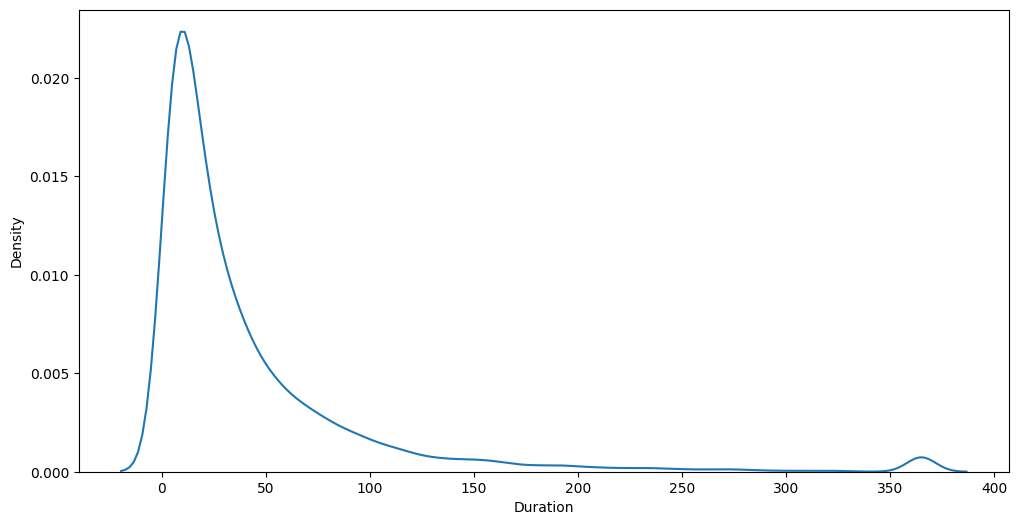

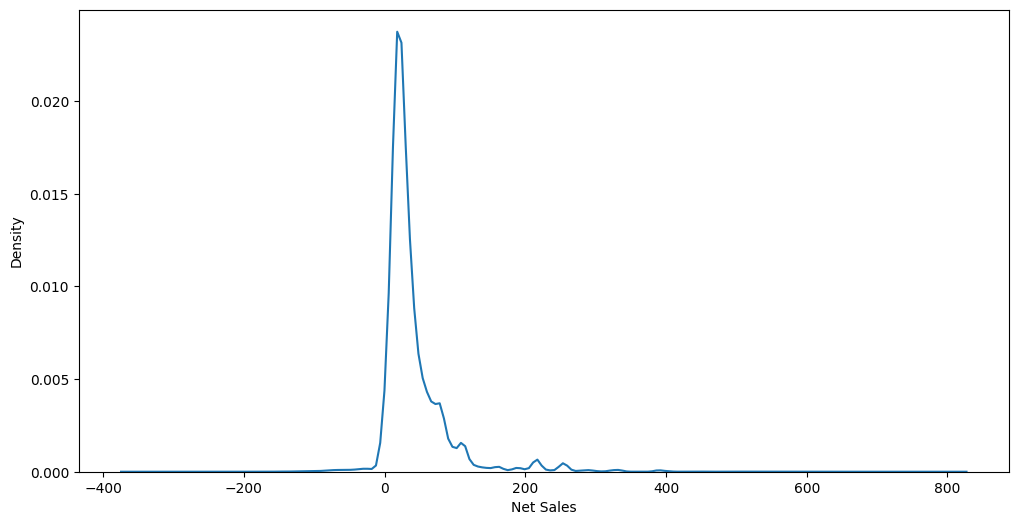

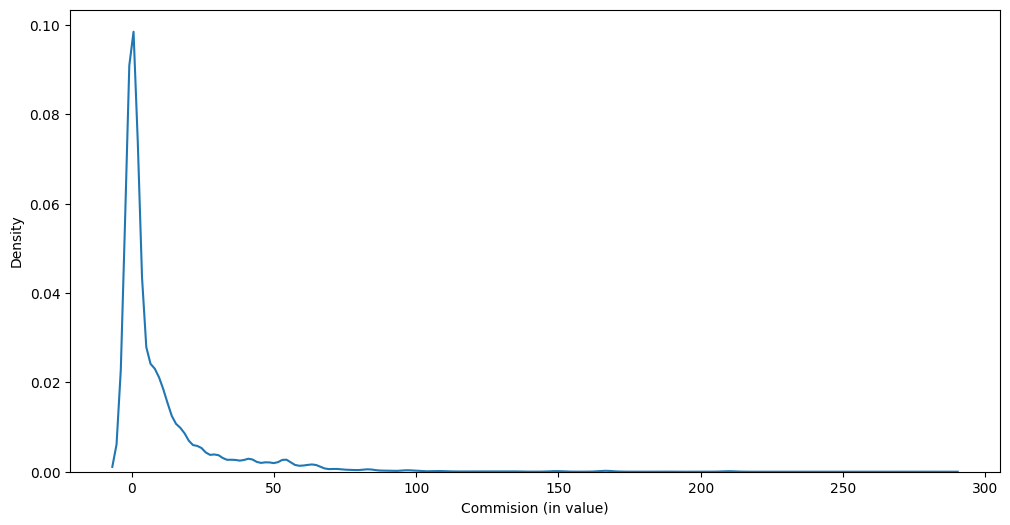

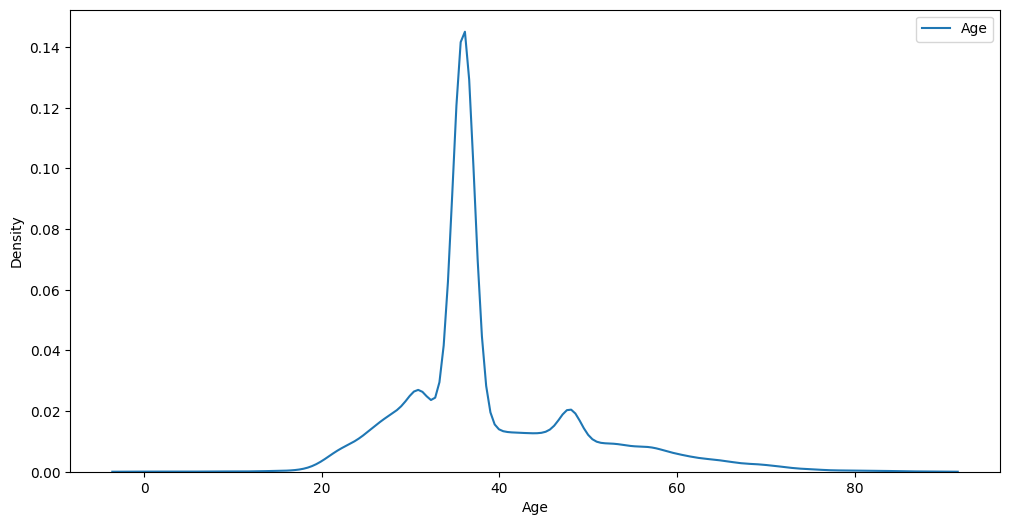

In [8]:
#2. Melihat skew (grafik)
plt.figure(figsize=(12,6))
for col in ['Duration']:
    sns.kdeplot(df[col], label=col)

plt.figure(figsize=(12,6))
for col in ['Net Sales']:
    sns.kdeplot(df[col], label=col)

plt.figure(figsize=(12,6))
for col in ['Commision (in value)']:
    sns.kdeplot(df[col], label=col)

plt.figure(figsize=(12,6))
for col in ['Age']:
    sns.kdeplot(df[col], label=col)

plt.legend()
plt.show()



Nilai Skew	Arti
* lebih dari 0.5 Data condong ke kanan (positively skewed)

* kurang dari 0.5	Data condong ke kiri (negatively skewed)

*  0.5 sampai 0.5	Distribusi simetris / normal






Setelah dibersihkan data menjadi condong kanan

In [9]:
df.describe()

,Duration,Net Sales,Commision (in value),Age
count,43471.000000,44328.000000,44328.000000,43652.000000
mean,41.943296,40.550948,9.707692,38.716531
std,58.063759,48.661970,19.625637,10.094275
min,1.000000,-357.500000,0.000000,0.000000
25%,9.000000,18.000000,0.000000,35.000000
50%,22.000000,26.500000,0.000000,36.000000
75%,50.000000,48.000000,11.550000,42.000000
max,366.000000,810.000000,283.500000,88.000000


Setelah data dibersihkan lebih masuk akal.
Menggunakan metode random forest, Xgboost, logistic regression, decision tree.

# Random Forest

In [10]:
# =======================================
# 1. PERSIAPAN DATASET
# =======================================
target_col = "Claim"
X = df.drop(columns=[target_col])
y = df[target_col]

# =======================================
# 2. SPLIT FITUR NUMERIK & KATEGORIK
# =======================================
num_cols = X.select_dtypes(include=['int64','float64']).columns
cat_cols = X.select_dtypes(include=['object']).columns

# =======================================
# 3. PREPROCESSING PIPELINE
#    - Numerical: median + scaling
#    - Categorical: mode + one-hot
# =======================================
num_transformer = Pipeline([
    ('imputer', SimpleImputer(strategy='median')),
    ('scaler', StandardScaler())
])

cat_transformer = Pipeline([
    ('imputer', SimpleImputer(strategy='most_frequent')),
    ('encoder', OneHotEncoder(handle_unknown='ignore'))
])

preprocessor = ColumnTransformer([
    ('num', num_transformer, num_cols),
    ('cat', cat_transformer, cat_cols)
])

# =======================================
# 4. TRAIN-TEST SPLIT
# =======================================
X_train, X_test, y_train, y_test = train_test_split(
    X, y,
    test_size=0.2,
    random_state=42,
    stratify=y
)

# =======================================
# 5. MODEL PIPELINE (Preprocess → SMOTE → RandomForest)
# =======================================
model = Pipeline([
    ('preprocess', preprocessor),
    ('smote', SMOTE(random_state=42)),
    ('rf', RandomForestClassifier(class_weight='balanced'))
])

# =======================================
# 6. RANDOMIZED SEARCH (Hyperparameter RF)
# =======================================
param_dist = {
    'rf__n_estimators': randint(100, 200),
    'rf__max_depth': randint(5, 20),
    'rf__min_samples_split': randint(2, 20),
    'rf__min_samples_leaf': randint(1, 10)
}

random_search = RandomizedSearchCV(
    model,
    param_distributions=param_dist,
    n_iter=5,
    cv=3,
    scoring='f1_macro',
    n_jobs=-1,
    random_state=42
)

random_search.fit(X_train, y_train)

print("Best Params :", random_search.best_params_)
print("Best Score :", random_search.best_score_)

# =======================================
# 7. PREDIKSI PROBABILITAS
# =======================================
y_train_proba = random_search.predict_proba(X_train)[:, 1]
y_test_proba  = random_search.predict_proba(X_test)[:, 1]

# =======================================
# 8. THRESHOLD TUNING (Manual)
# =======================================
threshold = 0.30  # contoh, bisa diganti PR/ROC

y_train_pred_tuned = (y_train_proba >= threshold).astype(int)
y_test_pred_tuned  = (y_test_proba  >= threshold).astype(int)

# ubah ke label Yes/No
y_train_pred_tuned = np.where(y_train_pred_tuned == 1, 'Yes', 'No')
y_test_pred_tuned  = np.where(y_test_pred_tuned  == 1, 'Yes', 'No')

# =======================================
# 9. EVALUASI MODEL
# =======================================
print("\n=== Classification Report (TRAIN, Threshold Tuned) ===")
print(classification_report(y_train, y_train_pred_tuned))

print("\n=== Classification Report (TEST, Threshold Tuned) ===")
print(classification_report(y_test, y_test_pred_tuned))

print("\n=== Confusion Matrix (TRAIN, Threshold Tuned) ===")
print(confusion_matrix(y_train, y_train_pred_tuned))

print("\n=== Confusion Matrix (TEST, Threshold Tuned) ===")
print(confusion_matrix(y_test, y_test_pred_tuned))


Best Params : {'rf__max_depth': 17, 'rf__min_samples_leaf': 5, 'rf__min_samples_split': 8, 'rf__n_estimators': 182}
Best Score : 0.5321892827618567

=== Classification Report (TRAIN, Threshold Tuned) ===
              precision    recall  f1-score   support

          No       1.00      0.72      0.84     34920
         Yes       0.05      0.89      0.09       542

    accuracy                           0.72     35462
   macro avg       0.52      0.80      0.46     35462
weighted avg       0.98      0.72      0.82     35462


=== Classification Report (TEST, Threshold Tuned) ===
              precision    recall  f1-score   support

          No       1.00      0.71      0.83      8731
         Yes       0.04      0.81      0.08       135

    accuracy                           0.71      8866
   macro avg       0.52      0.76      0.46      8866
weighted avg       0.98      0.71      0.82      8866


=== Confusion Matrix (TRAIN, Threshold Tuned) ===
[[25102  9818]
 [   62   480]]

=== 

# Xgboost

In [11]:
# ===============================
# 1. LOAD DATA
# ===============================
df = df.copy()
target_col = "Claim"

X = df.drop(columns=[target_col])
y = df[target_col]


# ===============================
# 2. LABEL ENCODING TARGET
# ===============================
le = LabelEncoder()
y_encoded = le.fit_transform(y)     # 'No' -> 0, 'Yes' -> 1


# ===============================
# 3. IMPUTASI MISSING VALUES
# ===============================
num_cols = X.select_dtypes(include=["int64", "float64"]).columns
cat_cols = X.select_dtypes(include=["object", "category"]).columns

# numerik → median
imputer_num = SimpleImputer(strategy="median")
X_num = pd.DataFrame(
    imputer_num.fit_transform(X[num_cols]),
    columns=num_cols
)

# kategori → modus
imputer_cat = SimpleImputer(strategy="most_frequent")
X_cat = pd.DataFrame(
    imputer_cat.fit_transform(X[cat_cols]),
    columns=cat_cols
)

# gabungkan kembali
X_clean = pd.concat([X_num, X_cat], axis=1)


# ===============================
# 4. ONE-HOT ENCODING
# ===============================
X_encoded = pd.get_dummies(
    X_clean,
    columns=cat_cols,
    drop_first=True
)


# ===============================
# 5. TRAIN-TEST SPLIT
# ===============================
X_train, X_test, y_train, y_test = train_test_split(
    X_encoded,
    y_encoded,
    test_size=0.20,
    random_state=42,
    stratify=y_encoded
)


# ===============================
# 6. SCALING
# ===============================
scaler = StandardScaler()

X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled  = scaler.transform(X_test)


# ===============================
# 7. SMOTE (Training Only)
# ===============================
sm = SMOTE(random_state=42)
X_train_sm, y_train_sm = sm.fit_resample(
    X_train_scaled,
    y_train
)


# ===============================
# 8. TRAIN XGBOOST
# ===============================
model = XGBClassifier(
    n_estimators  = 300,
    max_depth     = 5,
    learning_rate = 0.05,
    eval_metric   = "logloss",
    random_state  = 42
)

model.fit(X_train_sm, y_train_sm)


# ===============================
# 9. PREDIKSI PROBABILITAS
# ===============================
y_train_proba = model.predict_proba(X_train_scaled)[:, 1]
y_test_proba  = model.predict_proba(X_test_scaled)[:,  1]


# ===============================
# 10. THRESHOLD TUNING (ROC)
# ===============================
fpr, tpr, thresholds = roc_curve(y_train, y_train_proba)

best_threshold = thresholds[np.argmax(tpr - fpr)]
print("Best Threshold:", best_threshold)


# ===============================
# 11. PREDIKSI DENGAN THRESHOLD BARU
# ===============================
y_train_pred = (y_train_proba >= best_threshold).astype(int)
y_test_pred  = (y_test_proba  >= best_threshold).astype(int)


# ===============================
# 12. EVALUASI
# ===============================
print("\n=== Classification Report (TRAIN) ===")
print(classification_report(y_train, y_train_pred))

print("\n=== Classification Report (TEST) ===")
print(classification_report(y_test, y_test_pred))

print("\n=== Confusion Matrix (TRAIN) ===")
print(confusion_matrix(y_train, y_train_pred))

print("\n=== Confusion Matrix (TEST) ===")
print(confusion_matrix(y_test, y_test_pred))


Best Threshold: 0.28428215

=== Classification Report (TRAIN) ===
              precision    recall  f1-score   support

           0       1.00      0.78      0.88     34920
           1       0.06      0.86      0.11       542

    accuracy                           0.78     35462
   macro avg       0.53      0.82      0.49     35462
weighted avg       0.98      0.78      0.86     35462


=== Classification Report (TEST) ===
              precision    recall  f1-score   support

           0       0.99      0.78      0.87      8731
           1       0.05      0.71      0.09       135

    accuracy                           0.78      8866
   macro avg       0.52      0.74      0.48      8866
weighted avg       0.98      0.78      0.86      8866


=== Confusion Matrix (TRAIN) ===
[[27303  7617]
 [   76   466]]

=== Confusion Matrix (TEST) ===
[[6798 1933]
 [  39   96]]


# Logistic Regression

In [12]:
# ===============================
# 1. LOAD DATA
# ===============================
df = df.copy()
X = df.drop(columns=["Claim"])
y = df["Claim"]


# ===============================
# 2. IDENTIFIKASI KATEGORI & NUMERIK
# ===============================
num_cols = X.select_dtypes(include=["int64", "float64"]).columns
cat_cols = X.select_dtypes(include=["object"]).columns


# ===============================
# 3. PREPROCESSING (Imputer + Scaling + OneHot)
# ===============================
num_transformer = Pipeline([
    ("imputer", SimpleImputer(strategy="median")),
    ("scaler", StandardScaler())
])

cat_transformer = Pipeline([
    ("imputer", SimpleImputer(strategy="most_frequent")),
    ("onehot", OneHotEncoder(handle_unknown="ignore"))
])

preprocessor = ColumnTransformer([
    ("num", num_transformer, num_cols),
    ("cat", cat_transformer, cat_cols)
])


# ===============================
# 4. TRAIN-TEST SPLIT
# ===============================
X_train, X_test, y_train, y_test = train_test_split(
    X, y,
    test_size=0.20,
    random_state=42,
    stratify=y
)


# ===============================
# 5. PIPELINE (Preprocess → SMOTE → Logistic Regression)
# ===============================
model = Pipeline([
    ("preprocess", preprocessor),
    ("smote", SMOTE(random_state=42)),
    ("lr", LogisticRegression(
        max_iter=500,
        class_weight="balanced"
    ))
])


# ===============================
# 6. GRID SEARCH (Hyperparameter Tuning)
# ===============================
params = {
    "lr__C": [0.01, 0.1, 1, 10],
    "lr__penalty": ["l2"],
    "lr__solver": ["lbfgs"]
}

grid = GridSearchCV(
    estimator=model,
    param_grid=params,
    scoring="f1_macro",
    cv=3,
    n_jobs=-1
)

grid.fit(X_train, y_train)

print("Best Params:", grid.best_params_)
print("Best Score :", grid.best_score_)


# ===============================
# 7. FIT MODEL TERBAIK
# ===============================
best_model = grid.best_estimator_


# ===============================
# 8. PREDIKSI
# ===============================
y_train_pred = best_model.predict(X_train)
y_test_pred  = best_model.predict(X_test)


# ===============================
# 9. EVALUASI
# ===============================
print("\n=== Classification Report (TRAIN) ===")
print(classification_report(y_train, y_train_pred))

print("\n=== Classification Report (TEST) ===")
print(classification_report(y_test, y_test_pred))

print("\n=== Confusion Matrix (TRAIN) ===")
print(confusion_matrix(y_train, y_train_pred))

print("\n=== Confusion Matrix (TEST) ===")
print(confusion_matrix(y_test, y_test_pred))


Best Params: {'lr__C': 0.01, 'lr__penalty': 'l2', 'lr__solver': 'lbfgs'}
Best Score : 0.4958830999515073

=== Classification Report (TRAIN) ===
              precision    recall  f1-score   support

          No       0.99      0.81      0.89     34920
         Yes       0.06      0.73      0.10       542

    accuracy                           0.80     35462
   macro avg       0.53      0.77      0.50     35462
weighted avg       0.98      0.80      0.88     35462


=== Classification Report (TEST) ===
              precision    recall  f1-score   support

          No       0.99      0.81      0.89      8731
         Yes       0.05      0.72      0.10       135

    accuracy                           0.80      8866
   macro avg       0.52      0.76      0.50      8866
weighted avg       0.98      0.80      0.88      8866


=== Confusion Matrix (TRAIN) ===
[[28132  6788]
 [  144   398]]

=== Confusion Matrix (TEST) ===
[[7033 1698]
 [  38   97]]


Decision Tree

In [13]:
# ===============================
# 1. LOAD DATA
# ===============================
df = df.copy()
X = df.drop(columns=["Claim"])
y = df["Claim"]


# ===============================
# 2. IDENTIFIKASI KOLOM NUMERIK & KATEGORIK
# ===============================
num_cols = X.select_dtypes(include=["int64", "float64"]).columns
cat_cols = X.select_dtypes(include=["object"]).columns


# ===============================
# 3. PREPROCESSING (Imputer + Scaler + OneHot)
# ===============================
num_transformer = Pipeline([
    ("imputer", SimpleImputer(strategy="median")),
    ("scaler", StandardScaler())
])

cat_transformer = Pipeline([
    ("imputer", SimpleImputer(strategy="most_frequent")),
    ("encoder", OneHotEncoder(handle_unknown="ignore"))
])

preprocessor = ColumnTransformer([
    ("num", num_transformer, num_cols),
    ("cat", cat_transformer, cat_cols)
])


# ===============================
# 4. TRAIN–TEST SPLIT
# ===============================
X_train, X_test, y_train, y_test = train_test_split(
    X, y,
    test_size=0.20,
    random_state=42,
    stratify=y
)


# ===============================
# 5. PIPELINE (Preprocess → SMOTE → Decision Tree)
# ===============================
model = Pipeline([
    ("preprocess", preprocessor),
    ("smote", SMOTE(random_state=42)),
    ("dt", DecisionTreeClassifier(random_state=42))
])


# ===============================
# 6. RANDOM SEARCH (Hyperparameter Tuning)
# ===============================
param_dist = {
    "dt__max_depth": [3, 5, 10, 15, 20, None],
    "dt__min_samples_split": [2, 5, 10, 20],
    "dt__min_samples_leaf": [1, 2, 4, 6],
    "dt__criterion": ["gini", "entropy", "log_loss"]
}

search = RandomizedSearchCV(
    estimator=model,
    param_distributions=param_dist,
    n_iter=10,
    scoring="f1_macro",
    cv=3,
    n_jobs=-1,
    random_state=42
)

search.fit(X_train, y_train)

print("Best Params :", search.best_params_)
print("Best Score  :", search.best_score_)


# ===============================
# 7. PREDIKSI
# ===============================
y_pred_train = search.predict(X_train)
y_pred_test  = search.predict(X_test)


# ===============================
# 8. EVALUASI MODEL
# ===============================
print("\n=== CLASSIFICATION REPORT (TRAIN) ===")
print(classification_report(y_train, y_pred_train))

print("\n=== CLASSIFICATION REPORT (TEST) ===")
print(classification_report(y_test, y_pred_test))

print("\n=== CONFUSION MATRIX (TRAIN) ===")
print(confusion_matrix(y_train, y_pred_train))

print("\n=== CONFUSION MATRIX (TEST) ===")
print(confusion_matrix(y_test, y_pred_test))


Best Params : {'dt__min_samples_split': 20, 'dt__min_samples_leaf': 1, 'dt__max_depth': 3, 'dt__criterion': 'log_loss'}
Best Score  : 0.5361848556842984

=== CLASSIFICATION REPORT (TRAIN) ===
              precision    recall  f1-score   support

          No       0.99      0.89      0.94     34920
         Yes       0.07      0.58      0.13       542

    accuracy                           0.88     35462
   macro avg       0.53      0.73      0.53     35462
weighted avg       0.98      0.88      0.93     35462


=== CLASSIFICATION REPORT (TEST) ===
              precision    recall  f1-score   support

          No       0.99      0.89      0.94      8731
         Yes       0.07      0.56      0.13       135

    accuracy                           0.89      8866
   macro avg       0.53      0.72      0.54      8866
weighted avg       0.98      0.89      0.93      8866


=== CONFUSION MATRIX (TRAIN) ===
[[31025  3895]
 [  230   312]]

=== CONFUSION MATRIX (TEST) ===
[[7792  939]
 [  6

| Model                         | Recall YES | F1-score YES | FN (YES→NO) | FP (NO→YES) |
|-------------------------------|------------|--------------|-------------|-------------|
| Random Forest (tuned thresh.) | **0.78**   | 0.08         | 30          | 2501        |
| XGBoost (tuned)               | 0.71       | 0.09         | 39          | 1933        |
| Logistic Regression           | 0.72       | 0.10         | 38          | 1698        |
| Decision Tree (tuned)        | 0.56       | 0.13         | 60          | **939**     |



Berdasarkan hasil evaluasi beberapa model (Random Forest, XGBoost, Logistic Regression, dan Decision Tree), model Random Forest dengan threshold tuning menjadi pilihan terbaik. Alasannya adalah karena model ini memiliki sensitivitas tertinggi dalam mendeteksi kasus TRUE POSITIVE (kelas “YES”), yang berarti lebih baik dalam mengenali kejadian yang memang seharusnya terdeteksi sebagai risiko atau potensi fraud.

Model ini menghasilkan Recall YES sebesar 0.78, tertinggi dibanding model lainnya. Nilai recall yang tinggi menunjukkan bahwa model berhasil menangkap sebagian besar kejadian “YES”, sehingga jumlah FN (False Negative) menjadi paling sedikit. Ini sangat penting, karena FN adalah kejadian ketika sebuah kasus fraud justru lolos sebagai “aman”. Semakin rendah FN, semakin kecil risiko kerugian yang muncul akibat fraud yang tidak terdeteksi.

Dengan kata lain, Random Forest meminimalkan kelolosan fraud, sehingga memberikan proteksi yang lebih baik dibanding model lain.

Selain itu, Random Forest memang unggul dalam menangani data yang kompleks, memiliki banyak fitur, dan pola hubungan yang tidak linear. Model ini mampu belajar dari banyak pohon keputusan sehingga prediksinya lebih stabil, tidak mudah overfitting, dan lebih kuat terhadap noise.
Inilah yang membuat Random Forest tidak hanya akurat, tetapi juga lebih robust, terutama untuk kasus deteksi anomali atau fraud.

Dengan performa terbaik pada recall, jumlah FN paling rendah, serta stabilitas model yang kuat, Random Forest menjadi pilihan paling ideal untuk tujuan deteksi fraud. Penggunaan model ini membantu perusahaan:

* Mengurangi jumlah fraud yang lolos
(FN rendah)

* Memperkuat sistem pengawasan risiko

* Memberikan keputusan yang lebih akurat dan konsisten

* Menghasilkan model yang lebih tangguh pada data dunia nyata

Karena itulah, Random Forest menjadi model yang paling layak digunakan untuk kasus ini.

Untuk meningkatkan performa model, terutama dalam mendeteksi kelas YES (fraud/claim), fokus utama yang perlu dilakukan adalah:

1️⃣ Menambah Data YES

Karena jumlah YES sangat sedikit, model sulit belajar pola fraud. Menambah data YES akan meningkatkan recall dan F1-score secara signifikan.

2️⃣ Menambah Fitur (Feature Engineering)

Menambah fitur yang lebih informatif—seperti pola perilaku, frekuensi, waktu, dan perubahan nilai—akan membantu model mengenali fraud lebih akurat.

3️⃣ Meningkatkan Penanganan Imbalance

Selain SMOTE, bisa kombinasikan dengan metode lain (undersampling, SMOTE-Tomek, ADASYN) agar model tidak bias ke kelas NO.

4️⃣ Memperkuat Thresholding & Monitoring

Optimasi threshold dan pemantauan performa (recall YES, FN) secara rutin membantu menekan fraud yang lolos dan menjaga model tetap stabil.

#  Terima Kasih
